## Word Tokenizer exercise##

In this exercise, you are going to build a set of deep learning models on a (sort of) real world task using Tensorflow and Keras. Tensorflow is a deep learning framwork developed by Google, and Keras is a frontend library built on top of Tensorflow (or Theano, CNTK) to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for word tokenization in Thai (แบ่งเว้นวรรคภาษาไทย) using NECTEC's BEST corpus. You will build one model for each of the following type:
- Fully Connected (Feedforward) Neural Network
- One-Dimentional Convolution Neural Network (1D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for keras in this notebook but feel free to modify those parts to suit your needs. You can also complete this exercise using only Tensorflow (without using Keras). Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

**Don't forget to change hardware accelerator to GPU in Google Colab.**


In [ ]:
#Select tensorflow 2.0
%tensorflow_version 2.x

In [ ]:
# Run setup code
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
import tensorflow as tf
%matplotlib inline

In [ ]:
#Check GPU is available
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#Download dataset
gdd.download_file_from_google_drive(file_id='1iodAqVNWEkiJgH8cWkccsLi_tqoFcMrV',
                                    dest_path='./corpora.tar.gz')

In [ ]:
!tar xvzf corpora.tar.gz

corpora/
corpora/mnist_data/
corpora/mnist_data/t10k-images-idx3-ubyte.gz
corpora/mnist_data/train-images-idx3-ubyte.gz
corpora/mnist_data/.ipynb_checkpoints/
corpora/mnist_data/vis_utils.py
corpora/mnist_data/__init__.py
corpora/mnist_data/load_mnist.py
corpora/mnist_data/train-labels-idx1-ubyte.gz
corpora/mnist_data/t10k-labels-idx1-ubyte.gz
corpora/BEST/
corpora/BEST/test/
corpora/BEST/test/df_best_article_test.csv
corpora/BEST/test/df_best_encyclopedia_test.csv
corpora/BEST/test/df_best_novel_test.csv
corpora/BEST/test/df_best_news_test.csv
corpora/BEST/train/
corpora/BEST/train/df_best_encyclopedia_train.csv
corpora/BEST/train/df_best_article_train.csv
corpora/BEST/train/df_best_news_train.csv
corpora/BEST/train/df_best_novel_train.csv
corpora/BEST/val/
corpora/BEST/val/df_best_encyclopedia_val.csv
corpora/BEST/val/df_best_news_val.csv
corpora/BEST/val/df_best_article_val.csv
corpora/BEST/val/df_best_novel_val.csv
corpora/.ipynb_checkpoints/
corpora/.ipynb_checkpoints/Word_Tokeniz

In [ ]:
# Prepare data
# You don't need to run the following code as we already did it for you to give everyone the same dataset
# import cattern.data_utils
# cattern.data_utils.generate_best_dataset(os.getcwd()+'/data', create_val=True)

For simplicity, we are going to build a word tokenization model which is a binary classification model trying to predict whether a character is the begining of the word or not (if it is, then there is a space in front of it) and without using any knowledge about type of character (vowel, number, English character etc.).

For example,

'แมวดำน่ารักมาก' -> 'แมว ดำ น่า รัก มาก'

will have these true labels:

[(แ,1), (ม,0), (ว,0) (ด,1), ( ำ,0), (น,1), (-่,0), (า,0), (ร,1), (-ั,0), (ก,0), (ม,1), (า,0), (ก,0)]

In this task, we will use only main character you are trying to predict  and the characters that surround it (the context) as features. However, you can imagine that a more complex model will try to include more knowledge about each character into the model. You can do that too if you feel like it.

In [ ]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

In [ ]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used 
    as features for that character.
  
  Output:
  dataframe of size (N * n_pad) which each row contains the character, 
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]

In [ ]:
def prepare_feature(best_processed_path, option='train'):
  """
  Transform the path to a directory containing processed files 
  into a feature matrix and output array
  Input:
  best_processed_path: str, path to a processed version of the BEST dataset
  option: str, 'train' or 'test'
  """
  # we use padding equals 21 here to consider 10 characters to the left
  # and 10 characters to the right as features for the character in the middle
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'target': True}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = []
  # article types in BEST corpus
  article_types = ['article', 'encyclopedia', 'news', 'novel']
  for article_type in article_types:
      df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))
  
  df = pd.concat(df)
  # pad with empty string feature
  df = pd.concat((df_pad, df, df_pad))

  # map characters to numbers, use 'other' if not in the predefined character set.
  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

  # Use nearby characters as features
  df_with_context = create_n_gram_df(df, n_pad=n_pad)

  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

  # convert pandas dataframe to numpy array to feed to the model
  x_char = df_with_context[char_row].to_numpy()
  y = df_with_context['target'].astype(int).to_numpy()

  return x_char, y

Before running the following commands, we must inform you that our data is quite large and loading the whole dataset at once will **use a lot of memory (~6 GB after processing and up to ~12GB while processing)**. We expect you to be running this on Google Cloud or Google Colab so that you will not run into this problem. But, if, for any reason, you have to run this on your PC or machine with not enough memory, you might need to write a data generator to process a few entries at a time then feed it to the model while training.

For keras, you can use [fit_generator](https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory) to cope with that.

In [ ]:
# Path to the preprocessed data
best_processed_path = 'corpora/BEST'

In [ ]:
# Load preprocessed BEST corpus
x_train_char, y_train = prepare_feature(best_processed_path, option='train')
x_val_char, y_val = prepare_feature(best_processed_path, option='val')
x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# As a sanity check, we print out the size of the training, val, and test data.
print('Training data shape: ', x_train_char.shape)
print('Training data labels shape: ', y_train.shape)
print('Validation data shape: ', x_val_char.shape)
print('Validation data labels shape: ', y_val.shape)
print('Test data shape: ', x_test_char.shape)
print('Test data labels shape: ', y_test.shape)

Training data shape:  (16461637, 21)
Training data labels shape:  (16461637,)
Validation data shape:  (2035694, 21)
Validation data labels shape:  (2035694,)
Test data shape:  (2271932, 21)
Test data labels shape:  (2271932,)


In [ ]:
# Print some entry from the data to make sure it is the same as what you think.
print('First 3 features: ', x_train_char[:3])
print('First 30 class labels', y_train[:30])

First 3 features:  [[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]]
First 30 class labels [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [ ]:
#print char of feature 1
char = np.array(CHARS)

#A function for displaying our features in text
def print_features(tfeature,label,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    print(center + ': ' + word + "\tpred = "+str(label[index]))
    return center,word

for ind in range(0,30):
    print_features(x_train_char,y_train,ind)

ค:  ค ณะตุลาการร	pred = 1
ณ: ค ณ ะตุลาการรั	pred = 0
ะ: คณ ะ ตุลาการรัฐ	pred = 0
ต: คณะ ต ุลาการรัฐธ	pred = 0
ุ: คณะต ุ ลาการรัฐธร	pred = 0
ล: คณะตุ ล าการรัฐธรร	pred = 0
า: คณะตุล า การรัฐธรรม	pred = 0
ก: คณะตุลา ก ารรัฐธรรมน	pred = 0
า: คณะตุลาก า รรัฐธรรมนู	pred = 0
ร: คณะตุลากา ร รัฐธรรมนูญ	pred = 0
ร: คณะตุลาการ ร ัฐธรรมนูญก	pred = 0
ั: ณะตุลาการร ั ฐธรรมนูญกั	pred = 0
ฐ: ะตุลาการรั ฐ ธรรมนูญกับ	pred = 0
ธ: ตุลาการรัฐ ธ รรมนูญกับค	pred = 0
ร: ุลาการรัฐธ ร รมนูญกับคว	pred = 0
ร: ลาการรัฐธร ร มนูญกับควา	pred = 0
ม: าการรัฐธรร ม นูญกับความ	pred = 0
น: การรัฐธรรม น ูญกับความเ	pred = 0
ู: ารรัฐธรรมน ู ญกับความเป	pred = 0
ญ: รรัฐธรรมนู ญ กับความเป็	pred = 0
ก: รัฐธรรมนูญ ก ับความเป็น	pred = 1
ั: ัฐธรรมนูญก ั บความเป็นอ	pred = 0
บ: ฐธรรมนูญกั บ ความเป็นอง	pred = 0
ค: ธรรมนูญกับ ค วามเป็นองค	pred = 1
ว: รรมนูญกับค ว ามเป็นองค์	pred = 0
า: รมนูญกับคว า มเป็นองค์ก	pred = 0
ม: มนูญกับควา ม เป็นองค์กร	pred = 0
เ: นูญกับความ เ ป็นองค์กรต	pred = 1
ป: ูญกับความเ ป ็นองค์กรตุ	pred = 0
็: ญกับความ

Now, you are going to define the model to be used as your classifier. If you are using Keras, please follow the guideline we provide below. We encourage you to use the Keras Funtional API instead of the Sequential model as it is easier to create complex models (and to read your code). You can find more about Keras Functional API on Keras [documentation](https://keras.io/getting-started/functional-api-guide/).

You need to create a function that return a model you want and write code that invoke _**model.fit**_ to train your model. For example, your function ***get_nn()*** might looks like this:

```python
def get_nn():
  input1 = Input(...)
  ...
  # Create your wonderful model.
  ...
  out = ...
  model = Model(inputs=input1, outputs=out)
  model.compile(...)
return model
```

Also, beware that complex model requires more time to train and your dataset is already quite large. We tested it with a simple 1-hidden-layered feedforward nueral network and it used ~10 mins to train 1 epoch. It got more than 95% accuracy on validation set after the first epoch, so you should aim for a model with accuracy around 96-98%.

# Three-Layer Feedforward Neural Networks

Below, we provide you the code for creating a 3-layer fully connected neural network in keras. This will also serve as the baseline for your other models. Run the code below while making sure you understand what you are doing. Then, report the results.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

def get_feedforward_nn():
  input1 = Input(shape=(21,))
  x = Dense(100, activation='relu')(input1)
  x = Dense(100, activation='relu')(x)
  x = Dense(100, activation='relu')(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# This is called to clear the original model session in order to use TensorBoard
from tensorflow.keras import backend as K
K.clear_session()

# Path to save model parameters
weight_path_feedforward_nn='./model_weight_feedforward_nn.h5'

# Training callbacks list. TensorBoard() write logs for tensorboard GUI. 
# ModelCheckpoint() writes the resulting model.
# Note that writing to disk takes time (longer than model training time). 
# For other sections, you might not writing any files to disk 
# or write only the graph for TensorBoard.

callbacks_list_feedforward_nn = [
        TensorBoard(log_dir='./Graph/ff', histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            weight_path_feedforward_nn,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
model_feedforward_nn = get_feedforward_nn()
train_params = [(3, 512)]
for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} batch size".format(epochs, batch_size))
  model_feedforward_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                           callbacks=callbacks_list_feedforward_nn,
                           validation_data=(x_val_char, y_val))

start training
train with 3 epochs and 512 batch size
Epoch 1/3
32152/32152 [==============================] - 103s 3ms/step - loss: 0.4120 - acc: 0.8259 - val_loss: 0.2869 - val_acc: 0.8769

Epoch 00001: val_loss improved from inf to 0.28688, saving model to ./model_weight_feedforward_nn.h5
Epoch 2/3
32152/32152 [==============================] - 99s 3ms/step - loss: 0.2794 - acc: 0.8812 - val_loss: 0.2510 - val_acc: 0.8945

Epoch 00002: val_loss improved from 0.28688 to 0.25103, saving model to ./model_weight_feedforward_nn.h5
Epoch 3/3
32152/32152 [==============================] - 99s 3ms/step - loss: 0.2501 - acc: 0.8955 - val_loss: 0.2368 - val_acc: 0.9025

Epoch 00003: val_loss improved from 0.25103 to 0.23682, saving model to ./model_weight_feedforward_nn.h5


In [ ]:
y_train

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
################################################################################
# In case you want to close the session, you can re-load the model by          #
################################################################################
# weight_path_feedforward_nn='/data/model_weight_feedforward_nn.h5'
# model_feedforward_nn = get_feedforward_nn()
# model_feedforward_nn.load_weights(weight_path_feedforward_nn)
# model_feedforward_nn._make_predict_function()
# model_feedforward_nn.summary()

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score

################################################################################
# Write a function to evaluate your model. Your function must make prediction  #
# using the input model and return f-score, precision, and recall of the model.#
# You can make predictions by calling model.predict().                         #
################################################################################
def evaluate(x_test, y_test, model):
  """
  Evaluate model on the splitted 10 percent testing set.
  """
  y_pred = model.predict(x_test)

  #map probability to class
  prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
  y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
    
  f1score = f1_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred)
  return f1score, precision, recall

In [ ]:
evaluate(x_test_char, y_test, model_feedforward_nn)

(0.8280377621774719, 0.8369964995634541, 0.8192687723621543)

# Debugging

In order to understand what is going on in your model and where the error is, you should try looking at the inputs your model made wrong predictions.

In this task, write a function to print the characters on test data that got wrong prediction along with its context of size 10 (from [x-10] to [x+10]). Examine a fews of those and write your assumption on where the model got wrong prediction.

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5895cf2c18>)

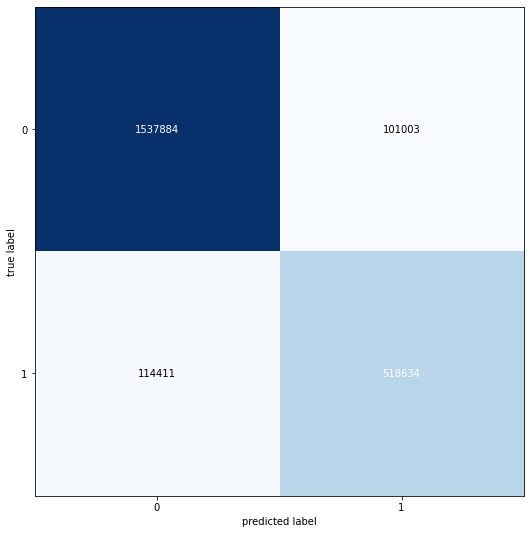

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = model_feedforward_nn.predict(x_test_char)

prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat = mat, show_normed = False, figsize = (9,9))

In [ ]:
def getFalsePositive(y_pred):
  global y_test
  out = []

  for i in range(len(y_pred)):
    if (y_pred[i] != y_test[i] and  y_pred[i] == 1):
      out.append(i)
  return out

def getFalseNegative(y_pred):
  global y_test
  out = []

  for i in range(len(y_pred)):
    if (y_pred[i] != y_test[i] and  y_pred[i] == 0):
      out.append(i)
  return out



In [ ]:
idx_of_fp = getFalsePositive(y_pred)
for k in idx_of_fp [0:10]:
  print_features(x_test_char,y_pred, k)

บ: ะวิธีคิดแบ บ แยกส่วนลด	pred = 1
ร: ศึกษาเรียน ร ู้"ในหลาย	pred = 1
ก: กระทรวงศึ ก ษาธิการทบ	pred = 1
า: ระทรวงศึกษ า ธิการทบวง	pred = 1
ก: รวงศึกษาธิ ก ารทบวงมหา	pred = 1
ม: ธิการทบวง ม หาวิทยาลัย	pred = 1
เ: มาอย่างต่อ เ นื่องยาวนา	pred = 1
น: อเนื่องยาว น าน(เหมือน	pred = 1
ภ: ่เรื่องสุข ภ าพเป็นเรื่	pred = 1
พ: ฐได้ถูกวิ พ ากษ์วิจารณ	pred = 1


In [ ]:
idx_of_fn = getFalseNegative(y_pred)
for k in idx_of_fn [0:10]:
  print_features(x_test_char,y_pred, k)

ท: งทางกระบวน ท ัศน์และบริ	pred = 0
บ: วนทัศน์และ บ ริบทสังคมไ	pred = 0
ส: น์และบริบท ส ังคมไทยThe	pred = 0
ไ: บริบทสังคม ไ ทยTheRefo	pred = 0
ก: erspective ก ระบวนทัศน์	pred = 0
ท: tiveกระบวน ท ัศน์และวิธ	pred = 0
แ: วิธีคิดแบบ แ ยกส่วนลดส	pred = 0
ส: ีคิดแบบแยก ส ่วนลดส่วน	pred = 0
ส: แยกส่วนลด ส ่วนได้ทำใ	pred = 0
เ: ้"การศึกษา เ รียนรู้"ใน	pred = 0


# Write your answer here

** I reckon a reason behind the wrong prediction is imperfection of model. In a tokenization task, it's need highly precision that mean if it do wrong for +1 -1 index (that show some in example above) it would be count as wrong and the construction of model could be improve with more compatible architecture**: TODO#2

# Tensorboard #
The code provided also have Tensorboard (a visualization tool that comes with Tensorflow). Note the part that calls it `TensorBoard(log_dir='./Graph/' + graph_name, histogram_freq=1, write_graph=True, write_grads=True)`. This tells Tensorflow to write extra outputs to the `log_dir` which can then be used for visualization.

To start tensorboard do
```
tensorboard --logdir=/full_path_to_your_logs
```

In Tensorboard, you will be able to debug your computation graph which can be hard to keep track in code. This is might seem trivial in Keras, but it is very helpful for Tensorflow. You can see a visualization of the computation graph at the `GRAPH` tab. If you see multiple dense layers (more than 4), this is caused by running the code several times without deleting the log dir. Delete the log dir and re-run the code.

Next, let's look at the scalars tab, we can see the loss and accuracy on the training and validation set as they change over each epoch. This can be useful to detect overfitting.

Another useful tab is the histograms tab (Enable by setting 'write_grads=True'). This plot histograms of the weights, biases, and outputs of each layer. The depth of the histograms show the change over epochs. We can see how the histograms of weights change over the training peroid. This can be used to debug vanishing gradients or getting stuck in local minimas.

There are other useful tabs in Tensorboard, you can read about them in the Keras [documentation](https://keras.io/callbacks/#tensorboard) for tensorboard.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./Graph/ff'

Reusing TensorBoard on port 6006 (pid 2186), started 0:38:31 ago. (Use '!kill 2186' to kill it.)

<IPython.core.display.Javascript object>

# Tensorboard observation

Write your own interpretation of the logs from this example. A simple sentence or two for each tab is sufficient.

**Scalars: Show how perfomance (accuracy, loss) of model change each iteration**
  
**Gparh: Show model architecture and it related components such as optimizer**

**Distribution: Show  distribution weight of bias and kernel in layers each iteration**

**Histrogram: Showing detail like Distribution tab but different way to represent and  easiler to observe and more beautiful**

**Time series: Showing the summary of above mentioned tabs**

  ****: TODO#3

# Dropout

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout to the model, run, and report the result again.

In [ ]:
# TODO#4
# Write a function that return feedforward model with dropout 
def get_nn_with_dropout():

  input1 = Input(shape=(21,))
  x = Dense(100, activation='relu')(input1)
  x = Dropout(0.1)(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation='relu')(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
# Train your model
from tensorflow.keras.layers import Dropout
print('start training')
verbose = 2
model_nn_with_dropout = get_nn_with_dropout()
# TODO#5
# Complete the code to train your model with dropout
################################################################################
              
callbacks_list_feedforward_nn_dropout = [
        TensorBoard(log_dir='./Graph/ff_dropout', histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            './model_weight_nn_with_dropout.h5',
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
train_params = [(3, 512)]
for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} 1".format(1, batch_size))
  model_nn_with_dropout.fit(x_train_char, y_train, epochs=1, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_nn_dropout,
                           validation_data=(x_val_char, y_val))                                  #
################################################################################


start training
start training
train with 1 epochs and 512 1
16076/16076 - 51s - loss: 0.4100 - acc: 0.8234 - val_loss: 0.3267 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.32669, saving model to ./model_weight_nn_with_dropout.h5


In [ ]:
evaluate(x_test_char, y_test, model_nn_with_dropout)

(0.7156603851595125, 0.8302118936548684, 0.6288873618779076)

# Convolution Neural Networks

Now, you are going to implement you own 1d-convolution neural networks with the following structure:
input -> embedding layer (size 32) -> 1D-convolution layer (100 filters of size 5, strides of 1) -> TimeDistributed (Dense size 5) -> fully-connected layer (size 100) -> output.

These parameters are simple guidelines to save your time. You can play with them in the final section.

The results should be better than the feedforward model.

Embedding layers turn the input from a one-hot vector into better representations via some feature transform (a simple matrix multiply in this case). TimeDistributed is Keras' way of specifying that the layer of the network should be distributed along time (the first dimension) as shown in the picture below.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_course/master/HW1/images/configuration.png">

Note you need to flatten() before the final fully connected layer because of dimension mis-match.

Do consult keras documentation on how to use [embedding layers](https://keras.io/layers/embeddings/) and [1D-cnn](https://keras.io/layers/convolutional/).


In [ ]:
################################################################################
# TODO#6:                                                                      #
# Write a function that returns keras convolution nueral network model.        #
# You can choose any normalization methods, activation function, as well as    #
# any hyperparameter the way you want. Your goal is to predict a score         #
# between [0,1] for each input whether it is the beginning of the word or not. #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################
from tensorflow.keras.layers import Conv1D, Embedding, TimeDistributed,Flatten


def get_conv1d_nn():

  input1 = Input(shape=(21,))
  x = Embedding(len(CHARS),32,input_length=21)(input1)

  x = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(x)
  
  x = TimeDistributed(Dense(5))(x)
  x = Flatten()(x)
  x = Dense(100, activation='relu')(x)

  out = Dense(1, activation='sigmoid')(x)
  

  


  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
get_conv1d_nn().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 21, 32)            5696      
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 100)           16100     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 5)             505       
_________________________________________________________________
flatten (Flatten)            (None, 105)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10600     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101 

In [ ]:
################################################################################
# TODO#7:                                                                      #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
################################################################################
print('start training conv1d')
model_conv1d_nn = get_conv1d_nn()
################################################################################
#    
callbacks_list_feedforward_cnn = [
        TensorBoard(log_dir='./Graph/ff_cnn', histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            './model_weight_nn_with_cnn.h5',
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 2
train_params = [(3, 512)]
for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} 3".format(3, batch_size))
  model_conv1d_nn.fit(x_train_char, y_train, epochs=3, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_cnn,
                           validation_data=(x_val_char, y_val))                       #
################################################################################


start training conv1d
start training
train with 3 epochs and 512 3
Epoch 1/3
16076/16076 - 109s - loss: 0.0823 - acc: 0.9683 - val_loss: 0.0677 - val_acc: 0.9748

Epoch 00001: val_loss improved from inf to 0.06770, saving model to ./model_weight_nn_with_cnn.h5
Epoch 2/3
16076/16076 - 102s - loss: 0.0591 - acc: 0.9781 - val_loss: 0.0616 - val_acc: 0.9773

Epoch 00002: val_loss improved from 0.06770 to 0.06157, saving model to ./model_weight_nn_with_cnn.h5
Epoch 3/3
16076/16076 - 102s - loss: 0.0544 - acc: 0.9800 - val_loss: 0.0579 - val_acc: 0.9791

Epoch 00003: val_loss improved from 0.06157 to 0.05791, saving model to ./model_weight_nn_with_cnn.h5


In [ ]:
evaluate(x_test_char, y_test, model_conv1d_nn)

(0.9657624543682494, 0.9595563296932574, 0.9720493803758027)

# GRU

Implement your GRU model with the following structure: input -> embedding layer (size 32) -> GRU layer (size 32) -> fully-connected layer (size 100) -> output.


These parameters are simple guidelines to save your time. You can play with them in the final section.

The result should be better than the feedforward model and at least on par with your CNN model.

Do consult keras documentation on how to use [embedding layers](https://keras.io/layers/embeddings/) and [GRUs](https://keras.io/layers/recurrent/).


In [ ]:


################################################################################
# TODO#8                                                                       #
# Write a function that returns keras GRU network moded. You can choose any    #
# normalization methods, activation function, as well as any hyperparameter    #
# the way you want. Your goal is to predict a score between [0,1] for each     #
# input whether it is the beginning of the word or not.                        #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################
from tensorflow.keras.layers import GRU
def get_gru():
  input1 = Input(shape=(21,))
  x = Embedding(len(CHARS),32,input_length=21)(input1)
  x = GRU(32, return_sequences=False, return_state=False)(x)
  
  x = Dense(100,activation = 'relu')(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
get_gru().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 21, 32)            5696      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 15,433
Trainable params: 15,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
################################################################################
# TODO#9                                                                       #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
################################################################################
print('start training gru')
model_gru = get_gru()
################################################################################
callbacks_list_feedforward_gru = [
        TensorBoard(log_dir='./Graph/ff_gpu', histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            './model_weight_nn_with_gru.h5',
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 2
train_params = [(3, 512)]
for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} 3".format(3, batch_size))
  model_gru.fit(x_train_char, y_train, epochs=3, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_gru,
                           validation_data=(x_val_char, y_val))                                                          #
################################################################################


start training gru
start training
train with 3 epochs and 512 3
Epoch 1/3
16076/16076 - 120s - loss: 0.1719 - acc: 0.9265 - val_loss: 0.0994 - val_acc: 0.9616

Epoch 00001: val_loss improved from inf to 0.09945, saving model to ./model_weight_nn_with_gru.h5
Epoch 2/3
16076/16076 - 118s - loss: 0.0869 - acc: 0.9666 - val_loss: 0.0816 - val_acc: 0.9698

Epoch 00002: val_loss improved from 0.09945 to 0.08164, saving model to ./model_weight_nn_with_gru.h5
Epoch 3/3
16076/16076 - 116s - loss: 0.0735 - acc: 0.9726 - val_loss: 0.0732 - val_acc: 0.9734

Epoch 00003: val_loss improved from 0.08164 to 0.07317, saving model to ./model_weight_nn_with_gru.h5


In [ ]:
evaluate(x_test_char, y_test, model_gru)

(0.9563683270521038, 0.9417115067175857, 0.9714885987568025)

# Final Section
# Keras playground

Now, train the best model you can do for this task. You can use any model structure and function available. Remember that trainig time increases with the complexity of the model. You might find TensorBoard helpful in tuning of complicated models.

Your model should be better than your CNN or GRU model in the previous sections.

Some ideas to try
1. Tune the parameters
2. Bi-directional GRU
3. CNN-GRU model

In [ ]:
################################################################################
# TODO#10                                                                      #
# Write a function that returns keras your best model. You can use anything    #
# you want. The goal here is to create the best model you can think of.        #
# Your model should get f-score more than 97% from calling evaluate().         #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, Embedding, TimeDistributed,Flatten


def get_my_best_model():

  input1 = Input(shape=(21,))
  x = Embedding(len(CHARS),32,input_length=21)(input1)

  x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', strides=1)(x)
  
  x = TimeDistributed(Dense(5))(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)

  out = Dense(1, activation='sigmoid')(x)
  

  


  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
################################################################################
# TODO#11                                                                      #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################
print('start training best model')
my_best_model = get_my_best_model()
################################################################################
################################################################################
callbacks_list_feedforward_best = [
        TensorBoard(log_dir='./Graph/ff_best', histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            './model_weight_nn_with_best.h5',
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
train_params = [(3, 512)]

for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} 3".format(5, batch_size*2))
  my_best_model.fit(x_train_char, y_train, epochs=5, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_best,
                           validation_data=(x_val_char, y_val))                              #
################################################################################

start training best model
start training
train with 5 epochs and 1024 3
Epoch 1/5
16076/16076 [==============================] - 124s 7ms/step - loss: 0.1114 - acc: 0.9555 - val_loss: 0.0672 - val_acc: 0.9752

Epoch 00001: val_loss improved from inf to 0.06716, saving model to ./model_weight_nn_with_best.h5
Epoch 2/5
16076/16076 [==============================] - 113s 7ms/step - loss: 0.0590 - acc: 0.9781 - val_loss: 0.0602 - val_acc: 0.9781

Epoch 00002: val_loss improved from 0.06716 to 0.06021, saving model to ./model_weight_nn_with_best.h5
Epoch 3/5
16076/16076 [==============================] - 113s 7ms/step - loss: 0.0531 - acc: 0.9806 - val_loss: 0.0577 - val_acc: 0.9792

Epoch 00003: val_loss improved from 0.06021 to 0.05772, saving model to ./model_weight_nn_with_best.h5
Epoch 4/5
16076/16076 [==============================] - 113s 7ms/step - loss: 0.0500 - acc: 0.9818 - val_loss: 0.0561 - val_acc: 0.9801

Epoch 00004: val_loss improved from 0.05772 to 0.05612, saving model to

In [ ]:
my_best_model.fit(x_train_char, y_train, epochs=1, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_best,
                           validation_data=(x_val_char, y_val)) 

16076/16076 [==============================] - 114s 7ms/step - loss: 0.0465 - acc: 0.9834 - val_loss: 0.0534 - val_acc: 0.9811

Epoch 00001: val_loss improved from 0.05612 to 0.05341, saving model to ./model_weight_nn_with_best.h5


In [ ]:
my_best_model.fit(x_train_char, y_train, epochs=1, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_best,
                           validation_data=(x_val_char, y_val)) 

16076/16076 [==============================] - 114s 7ms/step - loss: 0.0455 - acc: 0.9837 - val_loss: 0.0516 - val_acc: 0.9817

Epoch 00001: val_loss improved from 0.05341 to 0.05157, saving model to ./model_weight_nn_with_best.h5


In [ ]:
my_best_model.fit(x_train_char, y_train, epochs=1, batch_size=batch_size*2, verbose=verbose,
                           callbacks=callbacks_list_feedforward_best,
                           validation_data=(x_val_char, y_val)) 

16076/16076 [==============================] - 114s 7ms/step - loss: 0.0445 - acc: 0.9842 - val_loss: 0.0514 - val_acc: 0.9820

Epoch 00001: val_loss improved from 0.05157 to 0.05145, saving model to ./model_weight_nn_with_best.h5


In [ ]:
evaluate(x_test_char, y_test, my_best_model)

(0.97088964392434, 0.9643749922076627, 0.9774929112464359)